In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [88]:
# attack_type = 'none'
# datasets = 'pokec_n pokec_z credit bail dblp'.split()
datasets = 'pokec_z pokec_n dblp'.split()
models = 'gcn'.split()
df_results = pd.DataFrame()
for dataset in datasets:
    for model in models:
        for ptb_rate in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
            for attack_type in 'fair_attack prbcd dice random'.split():
                for target in 'y1s0 y1s1'.split():
                    for connection_type in 'DD'.split() if attack_type=='fair_attack' else ['None']:
                        c_attack_type = attack_type
                        if ptb_rate == 0: c_attack_type = 'none'
                        fname = f'../../results/result-{dataset}-{model}-{c_attack_type}' + ('' if c_attack_type=='none' else (f'-{ptb_rate:.2f}' if c_attack_type!='fair_attack' else f'-{target}-{connection_type}-deg0-null-{ptb_rate:.2f}')) +'.csv'
                        if not os.path.exists(fname):
                            fname = f'../../results/result-{dataset}-region-{model}-{c_attack_type}' + ('' if c_attack_type=='none' else (f'-{ptb_rate:.2f}' if c_attack_type!='fair_attack' else f'-{target}-{connection_type}-deg0-null-{ptb_rate:.2f}')) +'.csv'
                        if not os.path.exists(fname):
                            print(f'File not found: {fname}')
                            continue
                        df_current = pd.read_csv(fname)
                        df_current['dataset'] = dataset
                        df_current['model'] = model
                        df_current['attack_type'] = attack_type
                        df_current['ptb_rate'] = ptb_rate
                        df_current['Strategy']=connection_type
                        df_current['Target'] = target
                        df_results = pd.concat([df_results, df_current], ignore_index=True)

In [89]:
df_results.columns

Index(['acc', 'auc', 'precision', 'recall', 'maf1', 'mif1', 'yp1.a1', 'yp1.a0',
       'yp1.y1a1', 'yp1.y1a0', 'yp1.y0a1', 'yp1.y0a0', 'parity', 'equality',
       'eq_odds', 'dataset', 'model', 'attack_type', 'ptb_rate', 'Strategy',
       'Target'],
      dtype='object')

In [90]:
df_results['err_y1s1'] = 1-df_results['yp1.y1a1']
df_results['err_y0s0'] = df_results['yp1.y0a0']
df_results['err_y1s0'] = 1-df_results['yp1.y1a0']
df_results['err_y0s1'] = df_results['yp1.y0a1']

In [91]:
df_results['signed_parity'] = df_results['yp1.y0a0'] + df_results['yp1.y1a0'] - df_results['yp1.y1a1'] - df_results['yp1.y0a1']

In [92]:
df_results.loc[df_results.attack_type=='iter1','attack_type'] = 'MH-BFS'
df_results.loc[df_results.attack_type=='iter2','attack_type'] = 'MH-DFS'
df_results.loc[df_results.attack_type=='iter3','attack_type'] = 'MH-DFS-Rand'

In [93]:
df_results['Category'] = '_'

In [94]:
df_results.loc[df_results.attack_type=='dice','Category'] = 'Accuracy-targeting'
df_results.loc[df_results.attack_type=='random','Category'] = 'Baseline'
df_results.loc[df_results.attack_type=='prbcd','Category'] = 'Accuracy-targeting'
df_results.loc[df_results.attack_type=='fair_attack','Category'] = 'Ours'

In [95]:
df_results.loc[df_results.attack_type=='spih','attack_type'] = 'Inject+'
df_results.loc[df_results.attack_type=='spih-rev','attack_type'] = 'Inject-'
df_results.loc[df_results.attack_type=='rspis','attack_type'] = 'AnchorRewire+'
df_results.loc[df_results.attack_type=='rspis-rev','attack_type'] = 'AnchorRewire-'
df_results.loc[df_results.attack_type=='rspis2','attack_type'] = 'Rewire+'
df_results.loc[df_results.attack_type=='rspis-rev2','attack_type'] = 'Rewire-'
df_results.loc[df_results.attack_type=='sacide','attack_type'] = 'SA-CIDE'
df_results.loc[df_results.attack_type=='dice','attack_type'] = 'DICE'
df_results.loc[df_results.attack_type=='random','attack_type'] = 'Random'
df_results.loc[df_results.attack_type=='prbcd','attack_type'] = 'PR-BCD'

In [96]:
df_results.loc[(df_results.attack_type=='fair_attack') & (df_results.Target=='y1s1'),'attack_type'] = u'$y_1s_1$-DD'
df_results.loc[(df_results.attack_type=='fair_attack') & (df_results.Target=='y1s0'),'attack_type'] = u'$y_1s_0$-DD'

In [97]:
df_results['Attack'] = df_results.attack_type

In [98]:
df_results['attack'] = df_results.attack_type.apply(lambda x:x[:-1] if (x[-1] in '-+') else x)
df_results['direction'] = df_results.attack_type.apply(lambda x:x[-1] if (x[-1] in '-+') else '0')

In [99]:
df_results['_']=''

In [100]:
sns.set_style('whitegrid')

In [101]:
dataset_map = {'pokec_n':'Pokec_n', 'pokec_z':'Pokec_z', 'dblp':'DBLP'}

In [102]:
df_results['Dataset'] = df_results.dataset.apply(lambda x:dataset_map[x])

In [103]:
df_results['attack'].unique()

array(['$y_1s_0$-DD', '$y_1s_1$-DD', 'PR-BCD', 'DICE', 'Random'],
      dtype=object)

<Figure size 432x288 with 0 Axes>

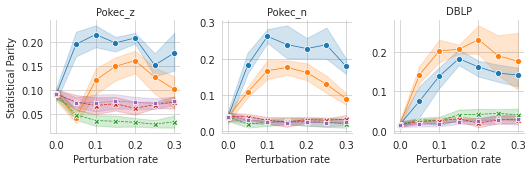

In [104]:
# for dataset in datasets:
# print('=======================' +  dataset + '=======================')
# for measure in 'parity err_y0s0 err_y0s1 err_y1s0 err_y1s1 acc'.split():
measure = 'parity'
plt.figure()
g = sns.FacetGrid(df_results, col='Dataset', sharey=False, height=2.5)
# for atks in [df_results.Attack.unique()[:2],['PR-BCD'],['DICE','Random']]:
#     print(atks)
g.map(sns.lineplot,'ptb_rate', measure,'Attack','_','Category', markers=True)
g.set_titles('{col_name}')
g.set_axis_labels("Perturbation rate", "Statistical Parity")


plt.savefig(f'../../reports/figures/{measure}-comparison.pdf', bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

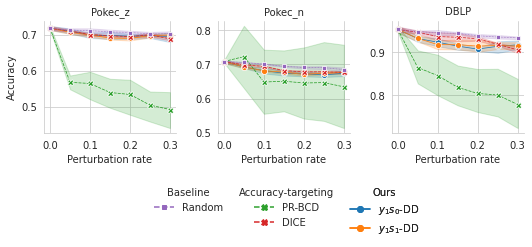

In [105]:
# for dataset in datasets:
# print('=======================' +  dataset + '=======================')
# for measure in 'parity err_y0s0 err_y0s1 err_y1s0 err_y1s1 acc'.split():
measure = 'acc'
plt.figure()
g = sns.FacetGrid(df_results, col='Dataset', sharey=False, height=2.5)
# for atks in [df_results.Attack.unique()[:2],['PR-BCD'],['DICE','Random']]:
#     print(atks)
g.map(sns.lineplot,'ptb_rate', measure,'Attack','_','Category', markers=True)
g.set_titles('{col_name}')
g.set_axis_labels("Perturbation rate", "Accuracy")
handles, labels = g.axes[0,-1].get_legend_handles_labels()

style_dict = {label: handle.get_linestyle()
              for handle, label in zip(handles[7:], labels[7:])}
marker_dict = {label: handle.get_marker()
              for handle, label in zip(handles[7:], labels[7:])}
attack_dict = {u'$y_1s_1$-DD':'Ours', u'$y_1s_0$-DD':'Ours', 'PR-BCD':'Accuracy-targeting', 'DICE':'Accuracy-targeting', 'Random':'Baseline'}

# loop through the items, assign color via the subscale of the item idem
for handle, label in zip(handles[1:6], labels[1:6]):
    handle.set_linestyle(style_dict[attack_dict[label]])
    handle.set_marker(marker_dict[attack_dict[label]])

l1 = plt.legend(bbox_to_anchor=(-1.25, -.45), loc='upper right',
                ncol=1, borderaxespad=0.,handles=handles[5:6],labels=labels[5:6],title='Baseline',frameon=False)
g.axes[0,-1].add_artist(l1)

l1 = plt.legend(bbox_to_anchor=(-.8, -.45), loc='upper center',
                ncol=1, borderaxespad=0.,handles=handles[3:5],labels=labels[3:5],title='Accuracy-targeting',frameon=False)
g.axes[0,-1].add_artist(l1)

l1 = plt.legend(bbox_to_anchor=(-.35, -.45), loc='upper left',
                ncol=1, borderaxespad=0.,handles=handles[1:3],labels=labels[1:3],title='Ours',frameon=False)
g.axes[0,-1].add_artist(l1)

plt.savefig(f'../../reports/figures/{measure}-comparison.pdf', bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

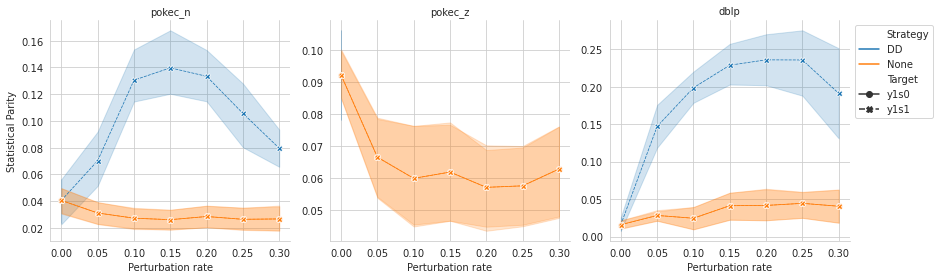

In [44]:
# for dataset in datasets:
# print('=======================' +  dataset + '=======================')
# for measure in 'parity err_y0s0 err_y0s1 err_y1s0 err_y1s1 acc'.split():
measure = 'parity'
plt.figure()
g = sns.FacetGrid(df_results, col='dataset', row='model', sharey=False, height=4)
g.map(sns.lineplot,'ptb_rate', measure, 'Strategy', '_', 'Target', markers=True)
g.set_titles('{col_name}')
g.set_axis_labels("Perturbation rate", "Statistical Parity")
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.savefig(f'../../reports/figures/{measure}.pdf', bbox_inches='tight')


In [ ]:
# for dataset in datasets:
# print('=======================' +  dataset + '=======================')
# for measure in 'parity err_y0s0 err_y0s1 err_y1s0 err_y1s1 acc'.split():
measure = 'parity'
plt.figure()
g = sns.FacetGrid(df_results, col='dataset', row='model', sharey=False, height=4)
g.map(sns.lineplot,'ptb_rate', measure, 'Strategy', '_', 'Target', markers=True)
g.set_titles('{col_name}')
g.set_axis_labels("Perturbation rate", "Statistical Parity")
plt.legend(bbox_to_anchor=(-2, -.3, 2.5, .102), loc='upper left',
                      ncol=8, mode="expand", borderaxespad=0.)
plt.savefig(f'../../reports/figures/{measure}.pdf', bbox_inches='tight')
